In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Parameters
scale = 0.05
x_min, x_max = -2, 1.0
y_min, y_max = -0.5, 2.0
num_samples = 10000
variable_range_x = np.linspace(-2, 1, 1000)
variable_range_y = np.linspace(-0.5, 2.5, 1000)

def compute_Muller_potential(scale, x):
    A = (-200.0, -100.0, -170.0, 15.0)
    beta = (0.0, 0.0, 11.0, 0.6)
    alpha_gamma = (
        x.new_tensor([-1.0, -10.0]),
        x.new_tensor([-1.0, -10.0]),
        x.new_tensor([-6.5, -6.5]),
        x.new_tensor([0.7, 0.7]),
    )

    ab = (
        x.new_tensor([1.0, 0.0]),
        x.new_tensor([0.0, 0.5]),
        x.new_tensor([-0.5, 1.5]),
        x.new_tensor([-1.0, 1.0]),
    )

    U = 0
    for i in range(4):
        diff = x - ab[i]
        U = U + A[i] * torch.exp(
            torch.sum(alpha_gamma[i] * diff**2, -1) + beta[i] * torch.prod(diff, -1)
        )

    U = scale * U
    return U

def rejection_sampling(fixed_value, variable_range, scale, fixed_is_x, num_samples=10000):
    accepted_samples = []

    # Compute the distirbution points = [[fixed_value, variable_range[0]], [fixed_value, variable_range[1]] ... ]
    points = torch.zeros((len(variable_range), 2))
    if fixed_is_x:
        points[:, 0] = fixed_value
        points[:, 1] = torch.tensor(variable_range)
    else:
        points[:, 0] = torch.tensor(variable_range)
        points[:, 1] = fixed_value
    potentials = -compute_Muller_potential(scale, points)
    max_potential = torch.max(potentials)
    
    # target distribution : f(x) = exp(-U(x)) / Z
    # Z = sum(exp(-U(x)))
    
    total_samples = 0
    while total_samples < num_samples:
        
        
        sample = np.random.uniform(variable_range[0], variable_range[-1])
        if fixed_is_x:
            point = torch.tensor([fixed_value, sample], dtype=torch.float32)
        else:
            point = torch.tensor([sample, fixed_value], dtype=torch.float32)

        potential = -compute_Muller_potential(scale, point)
        
        if np.log(np.random.uniform(0, 1)) <= potential - max_potential:
            accepted_samples.append(sample)
            total_samples += 1
            
    return accepted_samples


# Gibbs sampling function
def gibbs_sampling_Muller_potential(scale, num_samples, variable_range_x, variable_range_y):
    samples = np.zeros((num_samples, 2))
    
    for i in range(num_samples):
        # Initialize x and y
        x = np.random.uniform(variable_range_x[0], variable_range_x[-1])
        y = np.random.uniform(variable_range_y[0], variable_range_y[-1])
        
        # Sample x given y
        x = rejection_sampling(y, variable_range_x, scale, False, 1)[0]
        # Sample y given x
        y = rejection_sampling(x, variable_range_y, scale, True, 1)[0]

        samples[i] = [x, y]

    return samples

In [2]:
def generate_grid(x1_min, x1_max, x2_min, x2_max, size=100):
    x1 = torch.linspace(x1_min, x1_max, size)
    x2 = torch.linspace(x2_min, x2_max, size)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing="ij")
    grid = torch.stack([grid_x1, grid_x2], dim=-1)
    x = grid.reshape((-1, 2))
    return x


# Maximum and minimun from samples
grid_size = 100
x_grid = generate_grid(x_min, x_max, y_min, y_max, grid_size)
U = compute_Muller_potential(scale, x_grid)
U = U.reshape(100, 100)
U = U.T

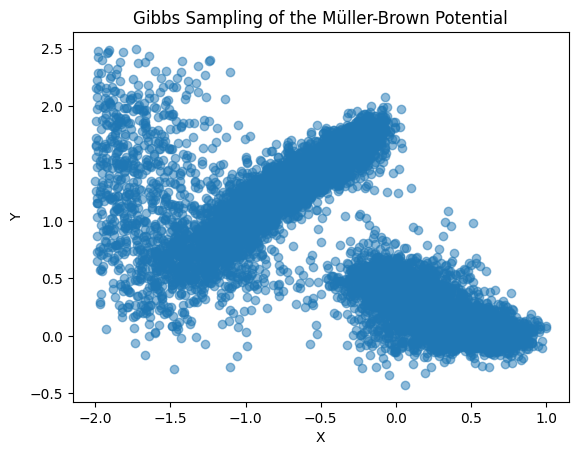

In [3]:
# Perform Gibbs sampling
samples = gibbs_sampling_Muller_potential(scale, num_samples, variable_range_x, variable_range_y)
# Plotting
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title('Gibbs Sampling of the Müller-Brown Potential')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

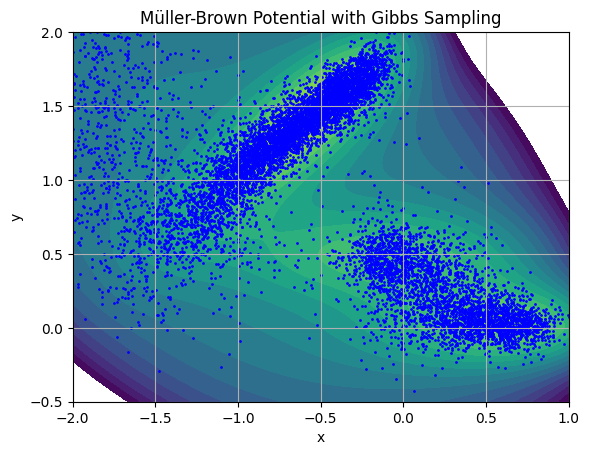

In [4]:
def generate_grid(x1_min, x1_max, x2_min, x2_max, size=100):
    x1 = torch.linspace(x1_min, x1_max, size)
    x2 = torch.linspace(x2_min, x2_max, size)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing="ij")
    grid = torch.stack([grid_x1, grid_x2], dim=-1)
    x = grid.reshape((-1, 2))
    return x


plt.contourf(
    U,
    levels=np.linspace(-9, 9, 19),
    extent=(x_min, x_max, y_min, y_max),
    cmap="viridis_r",
)
plt.scatter(samples[:, 0], samples[:, 1], s=1, color='blue')
plt.title('Müller-Brown Potential with Gibbs Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)
plt.show()

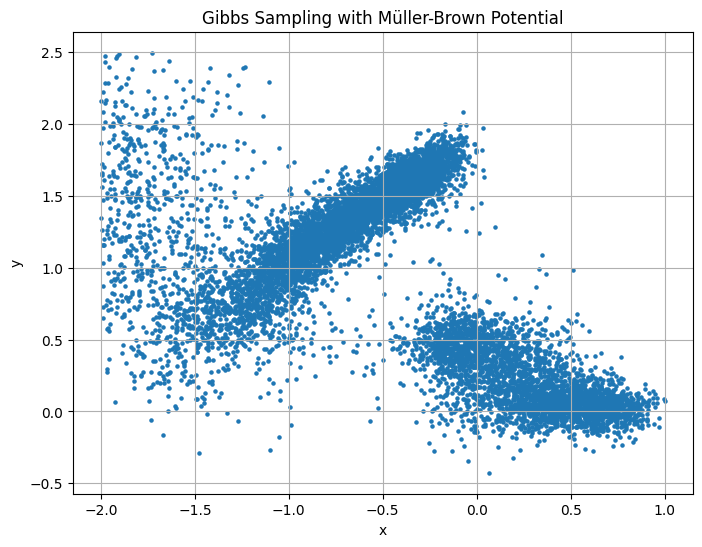

In [5]:
# Visualize the samples
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5)
plt.title("Gibbs Sampling with Müller-Brown Potential")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

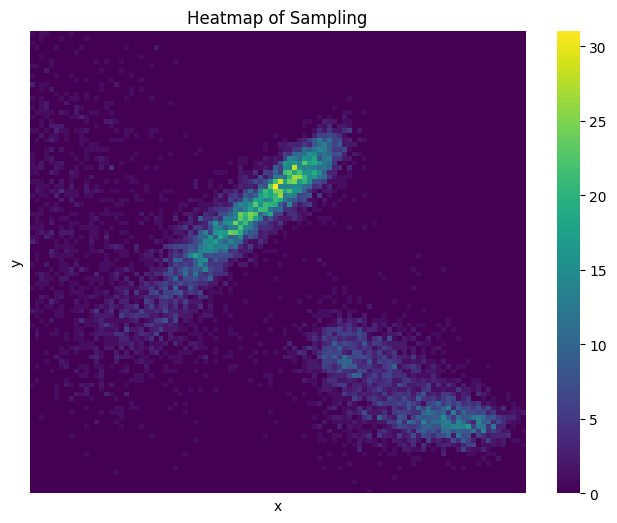

In [6]:
# Create a dataframe from the samples
df_samples = pd.DataFrame(samples, columns=['x', 'y'])

# Create a 2D histogram of the samples
heatmap, xedges, yedges = np.histogram2d(df_samples['x'], -df_samples['y'], bins=100)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap.T, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Heatmap of Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
